In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import collections
import pickle
import gc

In [2]:
df_nostr = pd.read_csv('yt_allcountry_trend5days_nostr.csv', index_col=None)

In [3]:
X = df_nostr.drop(['trend_over_5_days'],axis=1)
y = df_nostr['trend_over_5_days']

In [4]:
X

,views,likes,dislikes,comment_count
0,17158579,787425,43420,125882
1,1014651,127794,1688,13030
2,3191434,146035,5339,8181
3,2095828,132239,1989,17518
4,33523622,1634130,21082,85067
...,...,...,...,...
178694,279728,19691,135,579
178695,1549110,21905,1516,1318
178696,2183462,79677,2034,3464
178697,607422,26166,895,3517


In [5]:
y

0         1
1         0
2         1
3         1
4         1
         ..
178694    0
178695    0
178696    0
178697    0
178698    0
Name: trend_over_5_days, Length: 178699, dtype: int64

### PCA on 4 components?

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

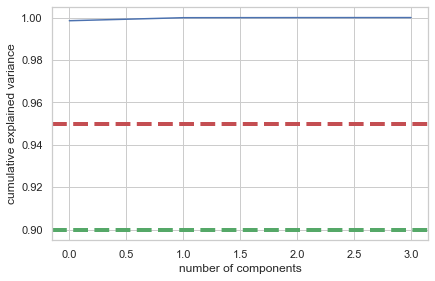

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.998518,0.998518
1,0.999936,0.001419
2,0.999983,0.000047
3,1.000000,0.000017


In [7]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
plt.axhline(linewidth=4, color='r', linestyle = '--', y=0.95, xmin=0, xmax=1)
plt.axhline(linewidth=4, color='g', linestyle = '--', y=0.90, xmin=0, xmax=1)

display(plt.show())

evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

## X use subsets

total n = 178699

1. n = 10000
2. n = 50000
3. n = 100000

## Then Test Train split

In [82]:
X_10k = X[:10000]
X_50k = X[:50000]
X_100k = X[:100000]

y_10k = y[:10000]
y_50k = y[:50000]
y_100k = y[:100000]

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_10k, X_test_10k, y_train_10k, y_test_10k = train_test_split(X_10k, y_10k, test_size=0.25, random_state=42)
X_train_50k, X_test_50k, y_train_50k, y_test_50k = train_test_split(X_50k, y_50k, test_size=0.25, random_state=42)
X_train_100k, X_test_100k, y_train_100k, y_test_100k = train_test_split(X_100k, y_100k, test_size=0.25, random_state=42)

In [75]:
X_train

,views,likes,dislikes,comment_count
113617,126706,6061,64,4418
65534,14658,122,21,9
126111,9568,141,5,10
8740,32051,3006,40,665
57496,11716,2018,6,130
...,...,...,...,...
119879,7996,38,8,14
103694,78227,1082,45,356
131932,98261,501,60,23
146867,16583,177,14,33


In [76]:
X_test

,views,likes,dislikes,comment_count
117989,2592,125,2,3
101258,30968,1900,32,219
44861,39277,720,72,312
5811,77884,814,119,617
63847,136815,362,201,375
...,...,...,...,...
131037,8259,569,4,86
112353,287445,1475,133,522
75019,78071,1191,42,33
93855,88752,1043,146,118


### Classifier 1: Naive Bayes - Gaussian Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [25]:
%%time
GNB = GaussianNB()
GNB.fit(X_train, y_train)

Wall time: 13.5 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
%%time
GNB.score(X_test, y_test)

Wall time: 4.5 ms


0.9582540570789032

In [32]:
%%time
GNB = GaussianNB()
GNB.fit(X_train_10k, y_train_10k)

GNB_predicted = GNB.predict(X_test_10k)
GNB_precision = precision_score(y_test_10k, GNB_predicted)
GNB_recall = recall_score(y_test_10k, GNB_predicted)
GNB_f1 = f1_score(y_test_10k, GNB_predicted)

print(f'Accuracy Score: {GNB.score(X_test_10k, y_test_10k)}')
print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Accuracy Score: 0.8952
Precision Score: 0.36363636363636365
Recall Score: 0.19213973799126638
F1 Score: 0.25142857142857145
Wall time: 5 ms


In [33]:
%%time
GNB = GaussianNB()
GNB.fit(X_train_50k, y_train_50k)

GNB_predicted = GNB.predict(X_test_50k)
GNB_precision = precision_score(y_test_50k, GNB_predicted)
GNB_recall = recall_score(y_test_50k, GNB_predicted)
GNB_f1 = f1_score(y_test_50k, GNB_predicted)

print(f'Accuracy Score: {GNB.score(X_test_50k, y_test_50k)}')
print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Accuracy Score: 0.94272
Precision Score: 0.32098765432098764
Recall Score: 0.2276707530647986
F1 Score: 0.26639344262295084
Wall time: 12.5 ms


In [34]:
%%time
GNB = GaussianNB()
GNB.fit(X_train_100k, y_train_100k)

GNB_predicted = GNB.predict(X_test_100k)
GNB_precision = precision_score(y_test_100k, GNB_predicted)
GNB_recall = recall_score(y_test_100k, GNB_predicted)
GNB_f1 = f1_score(y_test_100k, GNB_predicted)

print(f'Accuracy Score: {GNB.score(X_test_100k, y_test_100k)}')
print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Accuracy Score: 0.95164
Precision Score: 0.3523809523809524
Recall Score: 0.21700879765395895
F1 Score: 0.26860254083484575
Wall time: 21.5 ms


In [ ]:
%%time
from sklearn.model_selection import cross_val_score

GNB_cvs = cross_val_score(GNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {GNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(GNB_cvs)}")

In [61]:
print(len(GNB.predict_proba(X_test)))
GNB_probs = GNB.predict_proba(X_test)
GNB_probs
# print(min(GNB_probs[0])

44675


array([[9.99959840e-01, 4.01595651e-05],
       [9.99961288e-01, 3.87118523e-05],
       [9.99961262e-01, 3.87383677e-05],
       ...,
       [9.99961709e-01, 3.82905103e-05],
       [9.99962047e-01, 3.79534412e-05],
       [9.99960068e-01, 3.99317416e-05]])

In [ ]:
GNB_probs[:,0]

In [ ]:
GNB_probs[:,1]

In [ ]:
print(f"min of left col = {min(GNB_probs[:,0])}, max of right col = {max(GNB_probs[:,1])}")
print(f"max of left col = {max(GNB_probs[:,0])}, min of right col = {min(GNB_probs[:,1])}")

In [ ]:
len(GNB_probs[:,0])

In [ ]:
fig, ax = plt.subplots()
plt.scatter(GNB_probs[:,0], GNB_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 1')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [ ]:
for i, val in enumerate(GNB_probs[:,0]):
    if i < 10:
        print(i, val)

In [ ]:
xrange = [i for i in range(len(GNB_probs[:,0]))]
plt.scatter(xrange, GNB_probs[:,0])
plt.title('Probability of predicting Class 0')

plt.show()

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['views'], GNB_probs[:,1], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Views to Probability of Predicting Class 1', fontsize='small')
plt.xlabel('Views (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 1:\nA video trends for more than 5 days', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='lower right', title='Classes')
# ax.legend()

plt.show()

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['views'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Views to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Views (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0:\n A video trends for 5 or less days', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

In [ ]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['likes'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Likes to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Likes (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

In [ ]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['comment_count'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Comment Count to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Comment Count', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

In [ ]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['dislikes'], GNB_probs[:,0], 
                        c=y_test, 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Dislikes to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Dislikes Count', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

In [ ]:
# xrange = [i for i in range(len(GNB_probs[:,0]))]
plt.scatter(xrange, GNB_probs[:,1])
plt.title('Probability of predicting Class 1')

plt.show()

## Histogram to show quantity of predictions to probability

In [ ]:
from numpy import arange
bins = [i for i in arange(0.0, 1.0, 0.1)]
bins 

In [ ]:
import numpy as np

In [ ]:
bins = np.linspace(0.0,1.0, num=11)
bins

In [ ]:
plt.hist(GNB_probs[:,0], bins)
plt.title('Probability of Predicting Class 0 to Quantity of Predictions')

plt.show()

In [ ]:
bins2 = 10

plt.figure(figsize=(10, 8), dpi=100)

arr = plt.hist(GNB_probs[:,0], bins2,
#                c=,
              )

# plt.ylim(0,1000)
plt.yscale('log')
plt.title('Probability of Predicting Class 0 to Quantity of Predictions',fontsize='small')
plt.xlabel('Probability of Predicitng Class 0', fontsize='small')
plt.ylabel('Quantity of Predictions (log scale)', fontsize='small')
plt.rcParams.update({'font.size': 22})

for i in range(bins2):
    plt.text(arr[1][i]+0.01,
             arr[0][i]+1,
             str(arr[0][i]), 
             fontsize=14, 
            )
    plt.text(arr[1][i],
             arr[0][i]/1.5,
             str(), 
             fontsize=14, 
            )


plt.show()

In [ ]:
arr

In [ ]:
bins2 = 10
arr = plt.hist(GNB_probs[:,1], bins2)
plt.title('Probability of Predicting Class 1 to Quantity of Predictions')
plt.ylim(0,1000)
for i in range(bins2):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.show()

## Calibration Curves

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(clf_log, 'Logistic Regression'),
                  (GNB, 'Naive Bayes'),
                  (clf_svm_rbf, 'Support Vector Machine'),
                  (clf_rdf, 'Random Forest')]:
    
#     Already trained
#     clf.fit(X_train, y_train)

    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper left")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [ ]:
count = 0
for val in GNB_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(GNB_probs[:,1])}")

In [ ]:
# fig, ax = plt.subplots()

# x_val=len(GNB_probs)

# ax.bar(x_val, GNB_probs[:,0])


# ax.set_ylabel('Probability')
# ax.set_title('Probability of x_i being in class 0')
# plt.show()

In [ ]:
count = 0
for val in GNB_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [ ]:
 GNB.predict(X_test)

In [ ]:
GNB_predicted = GNB.predict(X_test)
GNB_precision = precision_score(y_test, GNB_predicted)
GNB_recall = recall_score(y_test, GNB_predicted)
GNB_f1 = f1_score(y_test, GNB_predicted)

print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

### Classifier 1b: Bernoulli Naive Bayes

In [ ]:
%%time
BNB = BernoulliNB()
BNB.fit(X_train, y_train)

In [ ]:
%%time
BNB.score(X_test, y_test)

In [ ]:
%%time
from sklearn.model_selection import cross_val_score

BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

In [ ]:
BNB_predicted = BNB.predict(X_test)
BNB_precision = precision_score(y_test, BNB_predicted)
BNB_recall = recall_score(y_test, BNB_predicted)
BNB_f1 = f1_score(y_test, BNB_predicted)

print(f'Predicted Array: {BNB_predicted}')
print(f'Precision Score: {BNB_precision}')
print(f'Recall Score: {BNB_recall}')
print(f'F1 Score: {BNB_f1}')

### Classifier 2: Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
%%time
clf_log = LogisticRegression(random_state=42,
                            verbose=2,
                            n_jobs=-1,)
clf_log.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished


Wall time: 1.5 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=2, warm_start=False)

In [37]:
%%time
clf_log.score(X_test,y_test)

Wall time: 3 ms


0.9639395635142697

In [ ]:
# %%time
# from sklearn.model_selection import cross_val_score

# clf_log_cvs = cross_val_score(clf_log, X, y, 
#                               cv=10, 
#                               n_jobs=-1,)

# print(f"GaussianNB 10-CV score: {clf_log_cvs}")
# print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_log_cvs)}")

In [38]:
clf_log_predicted = clf_log.predict(X_test)
clf_log_precision = precision_score(y_test, clf_log_predicted)
clf_log_recall = recall_score(y_test, clf_log_predicted)
clf_log_f1 = f1_score(y_test, clf_log_predicted)

print(f'Predicted Array: {clf_log_predicted}')
print(f'Precision Score: {clf_log_precision}')
print(f'Recall Score: {clf_log_recall}')
print(f'F1 Score: {clf_log_f1}')

Predicted Array: [0 0 0 ... 0 0 0]
Precision Score: 0.037037037037037035
Recall Score: 0.008233532934131737
F1 Score: 0.013472137170851195


In [39]:
%%time
clf_log = LogisticRegression(random_state=42,
                            verbose=2,
                            n_jobs=-1,)
clf_log.fit(X_train_10k,y_train_10k)

clf_log_predicted = GNB.predict(X_test_10k)
clf_log_precision = precision_score(y_test_10k, clf_log_predicted)
clf_log_recall = recall_score(y_test_10k, clf_log_predicted)
clf_log_f1 = f1_score(y_test_10k, clf_log_predicted)

print(f'Accuracy Score:  {clf_log.score(X_test_10k, y_test_10k)}')
print(f'Precision Score: {clf_log_precision}')
print(f'Recall Score:    {clf_log_recall}')
print(f'F1 Score:        {clf_log_f1}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Accuracy Score:  0.8756
Precision Score: 0.34615384615384615
Recall Score:    0.23580786026200873
F1 Score:        0.2805194805194805
Wall time: 307 ms


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [40]:
%%time
clf_log = LogisticRegression(random_state=42,
                            verbose=2,
                            n_jobs=-1,)
clf_log.fit(X_train_50k,y_train_50k)

clf_log_predicted = GNB.predict(X_test_50k)
clf_log_precision = precision_score(y_test_50k, clf_log_predicted)
clf_log_recall = recall_score(y_test_50k, clf_log_predicted)
clf_log_f1 = f1_score(y_test_50k, clf_log_predicted)

print(f'Accuracy Score:  {clf_log.score(X_test_50k, y_test_50k)}')
print(f'Precision Score: {clf_log_precision}')
print(f'Recall Score:    {clf_log_recall}')
print(f'F1 Score:        {clf_log_f1}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Accuracy Score:  0.9272
Precision Score: 0.3192389006342495
Recall Score:    0.26444833625218916
F1 Score:        0.289272030651341
Wall time: 621 ms


In [41]:
%%time
clf_log = LogisticRegression(random_state=42,
                            verbose=2,
                            n_jobs=-1,)
clf_log.fit(X_train_100k,y_train_100k)

clf_log_predicted = GNB.predict(X_test_100k)
clf_log_precision = precision_score(y_test_100k, clf_log_predicted)
clf_log_recall = recall_score(y_test_100k, clf_log_predicted)
clf_log_f1 = f1_score(y_test_100k, clf_log_predicted)

print(f'Accuracy Score:  {clf_log.score(X_test_100k, y_test_100k)}')
print(f'Precision Score: {clf_log_precision}')
print(f'Recall Score:    {clf_log_recall}')
print(f'F1 Score:        {clf_log_f1}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


Accuracy Score:  0.95952
Precision Score: 0.3523809523809524
Recall Score:    0.21700879765395895
F1 Score:        0.26860254083484575
Wall time: 1.17 s


In [ ]:
log_probs = clf_log.predict_proba(X_test)

In [ ]:
print(f"min of left col = {min(log_probs[:,0])}, max of right col = {max(log_probs[:,1])}")
print(f"max of left col = {max(log_probs[:,0])}, min of right col = {min(log_probs[:,1])}")

In [ ]:
fig, ax = plt.subplots()
plt.scatter(log_probs[:,0], log_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [ ]:
count = 0
for val in log_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")

In [ ]:
count = 0
for val in log_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(log_probs[:,1])}")

### Classifier 3: Support Vector Machine (SVC)

In [54]:
from sklearn.svm import SVC, LinearSVC

In [ ]:
%%time
clf_svm_rbf = SVC(probability=True,
                  kernel='rbf',
                  verbose=2,
                  random_state=42,)

clf_svm_rbf.fit(X_train,y_train)

In [ ]:
%%time
clf_svm_rbf.score(X_test,y_test)

In [ ]:
# %%time
# clf_svm_rbf_cvs = cross_val_score(clf_svm_rbf, X, y, 
#                               cv=10, 
#                               n_jobs=-1,)

# print(f"GaussianNB 10-CV score: {clf_svm_rbf_cvs}")
# print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_svm_rbf_cvs)}")

In [ ]:
# clf_svm_rbf_predicted = clf_svm_rbf.predict(X_test)
# clf_svm_rbf_precision = precision_score(y_test, clf_svm_rbf_predicted)
# clf_svm_rbf_recall = recall_score(y_test, clf_svm_rbf_predicted)
# clf_svm_rbf_f1 = f1_score(y_test, clf_svm_rbf_predicted)

# print(f'Precision Score: {clf_svm_rbf_precision}')
# print(f'Recall Score: {clf_svm_rbf_recall}')
# print(f'F1 Score: {clf_svm_rbf_f1}')

In [55]:
%%time
clf_svm_rbf = SVC(probability=True,
                  kernel='rbf',
                  verbose=2,
                  random_state=42,)

clf_svm_rbf.fit(X_train_10k, y_train_10k)

clf_svm_rbf_predicted = clf_svm_lin.predict(X_test_10k)
clf_svm_rbf_precision = precision_score(y_test_10k, clf_svm_rbf_predicted)
clf_svm_rbf_recall = recall_score(y_test_10k, clf_svm_rbf_predicted)
clf_svm_rbf_f1 = f1_score(y_test_10k, clf_svm_rbf_predicted)

print(f'Accuracy Score:  {clf_svm_rbf.score(X_test_10k, y_test_10k)}')
print(f'Precision Score: {clf_svm_rbf_precision}')
print(f'Recall Score: {clf_svm_rbf_recall}')
print(f'F1 Score: {clf_svm_rbf_f1}')

[LibSVM]Accuracy Score:  0.9084
Precision Score: 0.9516129032258065
Recall Score: 0.7729257641921398
F1 Score: 0.8530120481927711
Wall time: 1.54 s


In [56]:
%%time
clf_svm_rbf = SVC(probability=True,
                  kernel='rbf',
                  verbose=2,
                  random_state=42,)

clf_svm_rbf.fit(X_train_50k, y_train_50k)

clf_svm_rbf_predicted = clf_svm_lin.predict(X_test_50k)
clf_svm_rbf_precision = precision_score(y_test_50k, clf_svm_rbf_predicted)
clf_svm_rbf_recall = recall_score(y_test_50k, clf_svm_rbf_predicted)
clf_svm_rbf_f1 = f1_score(y_test_50k, clf_svm_rbf_predicted)

print(f'Accuracy Score:  {clf_svm_rbf.score(X_test_50k, y_test_50k)}')
print(f'Precision Score: {clf_svm_rbf_precision}')
print(f'Recall Score: {clf_svm_rbf_recall}')
print(f'F1 Score: {clf_svm_rbf_f1}')

[LibSVM]Accuracy Score:  0.95488
Precision Score: 0.9378109452736318
Recall Score: 0.660245183887916
F1 Score: 0.774922918807811
Wall time: 18.1 s


In [57]:
%%time
clf_svm_rbf = SVC(probability=True,
                  kernel='rbf',
                  verbose=2,
                  random_state=42,)

clf_svm_rbf.fit(X_train_100k, y_train_100k)

clf_svm_rbf_predicted = clf_svm_lin.predict(X_test_100k)
clf_svm_rbf_precision = precision_score(y_test_100k, clf_svm_rbf_predicted)
clf_svm_rbf_recall = recall_score(y_test_100k, clf_svm_rbf_predicted)
clf_svm_rbf_f1 = f1_score(y_test_100k, clf_svm_rbf_predicted)

print(f'Accuracy Score:  {clf_svm_rbf.score(X_test_100k, y_test_100k)}')
print(f'Precision Score: {clf_svm_rbf_precision}')
print(f'Recall Score: {clf_svm_rbf_recall}')
print(f'F1 Score: {clf_svm_rbf_f1}')

[LibSVM]Accuracy Score:  0.95932
Precision Score: 0.52046783625731
Recall Score: 0.08699902248289346
F1 Score: 0.1490787269681742
Wall time: 1min 1s


In [ ]:
svm_rbf_probs = GNB.predict_proba(X_test)

In [ ]:
print(f"min of left col = {min(svm_rbf_probs[:,0])}, max of right col = {max(svm_rbf_probs[:,1])}")
print(f"max of left col = {max(svm_rbf_probs[:,0])}, min of right col = {min(svm_rbf_probs[:,1])}")

In [ ]:
fig, ax = plt.subplots()
plt.scatter(svm_rbf_probs[:,0], svm_rbf_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [ ]:
count = 0
for val in svm_rbf_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")
print(f"% of val around 0.5 = {count/len(svm_rbf_probs[:,1])}")

In [ ]:
count = 0
for val in svm_rbf_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(svm_rbf_probs[:,1])}")

### LinearSVC

In [ ]:
%%time
from sklearn.svm import LinearSVC

clf_svm_lin = LinearSVC(
#                         probability=True,
                         verbose=2,
                         random_state=42,)

clf_svm_lin.fit(X_train,y_train)

In [ ]:
%%time
clf_svm_lin.score(X_test,y_test)

%%time
from sklearn.model_selection import cross_val_score

clf_svm_lin_cvs = cross_val_score(clf_svm_lin, X, y, 
                              cv=10, 
                              n_jobs=-1,)

print(f"GaussianNB 10-CV score: {clf_svm_lin_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_svm_lin_cvs)}")

In [ ]:
svm_lin_probs = GNB.predict_proba(X_test)

In [ ]:
print(f"min of left col = {min(svm_lin_probs[:,0])}, max of right col = {max(svm_lin_probs[:,1])}")
print(f"max of left col = {max(svm_lin_probs[:,0])}, min of right col = {min(svm_lin_probs[:,1])}")

In [ ]:
fig, ax = plt.subplots()
plt.scatter(svm_lin_probs[:,0], svm_lin_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [ ]:
count = 0
for val in svm_lin_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")
print(f"% of val around 0.5 = {count/len(svm_lin_probs[:,1])}")

In [ ]:
count = 0
for val in svm_lin_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(svm_lin_probs[:,1])}")

### Classifier 4: Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
%%time
clf_rdf = RandomForestClassifier(n_jobs=-1,
                       random_state=42,
#                        verbose=2,
                                )

clf_rdf.fit(X_train,y_train)

Wall time: 1.33 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [44]:
%%time
clf_rdf.score(X_test,y_test)

Wall time: 110 ms


0.97011751538892

In [ ]:
# %%time
# from sklearn.model_selection import cross_val_score

# clf_rdf_cvs = cross_val_score(clf_rdf, X, y, 
#                               cv=10, 
#                               n_jobs=-1,)

# print(f"GaussianNB 10-CV score: {clf_rdf_cvs}")
# print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(clf_rdf_cvs)}")

In [46]:
%%time
clf_rdf = RandomForestClassifier(n_jobs=-1,
                       random_state=42,
#                        verbose=2,
                                )
clf_rdf.fit(X_train_10k,y_train_10k)

clf_rdf_predicted = clf_rdf.predict(X_test_10k)
clf_rdf_precision = precision_score(y_test_10k, clf_rdf_predicted)
clf_rdf_recall = recall_score(y_test_10k, clf_rdf_predicted)
clf_rdf_f1 = f1_score(y_test_10k, clf_rdf_predicted)

print(f'Accuracy Score:  {clf_rdf.score(X_test_10k, y_test_10k)}')
print(f'Precision Score: {clf_rdf_precision}')
print(f'Recall Score: {clf_rdf_recall}')
print(f'F1 Score: {clf_rdf_f1}')

Accuracy Score:  0.9028
Precision Score: 0.3870967741935484
Recall Score: 0.10480349344978165
F1 Score: 0.1649484536082474
Wall time: 461 ms


In [47]:
%%time
clf_rdf = RandomForestClassifier(n_jobs=-1,
                       random_state=42,
#                        verbose=2,
                                )
clf_rdf.fit(X_train_50k,y_train_50k)

clf_rdf_predicted = clf_rdf.predict(X_test_50k)
clf_rdf_precision = precision_score(y_test_50k, clf_rdf_predicted)
clf_rdf_recall = recall_score(y_test_50k, clf_rdf_predicted)
clf_rdf_f1 = f1_score(y_test_50k, clf_rdf_predicted)

print(f'Accuracy Score:  {clf_rdf.score(X_test_50k, y_test_50k)}')
print(f'Precision Score: {clf_rdf_precision}')
print(f'Recall Score: {clf_rdf_recall}')
print(f'F1 Score: {clf_rdf_f1}')

Accuracy Score:  0.95432
Precision Score: 0.5
Recall Score: 0.0840630472854641
F1 Score: 0.14392803598200898
Wall time: 592 ms


In [49]:
%%time
clf_rdf = RandomForestClassifier(n_jobs=-1,
                       random_state=42,
#                        verbose=2,
                                )
clf_rdf.fit(X_train_100k,y_train_100k)

clf_rdf_predicted = clf_rdf.predict(X_test_100k)
clf_rdf_precision = precision_score(y_test_100k, clf_rdf_predicted)
clf_rdf_recall = recall_score(y_test_100k, clf_rdf_predicted)
clf_rdf_f1 = f1_score(y_test_100k, clf_rdf_predicted)

print(f'Accuracy Score:  {clf_rdf.score(X_test_100k, y_test_100k)}')
print(f'Precision Score: {clf_rdf_precision}')
print(f'Recall Score: {clf_rdf_recall}')
print(f'F1 Score: {clf_rdf_f1}')

Accuracy Score:  0.95936
Precision Score: 0.52046783625731
Recall Score: 0.08699902248289346
F1 Score: 0.1490787269681742
Wall time: 954 ms


In [ ]:
rdf_probs = GNB.predict_proba(X_test)

In [ ]:
print(f"min of left col = {min(rdf_probs[:,0])}, max of right col = {max(rdf_probs[:,1])}")
print(f"max of left col = {max(rdf_probs[:,0])}, min of right col = {min(rdf_probs[:,1])}")

In [ ]:
fig, ax = plt.subplots()
plt.scatter(rdf_probs[:,0], rdf_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

In [ ]:
count = 0
for val in rdf_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")
print(f"% of val around 0.5 = {count/len(rdf_probs[:,1])}")

In [ ]:
count = 0
for val in rdf_probs[:,1]:
    if val >= 0.9:
        count += 1
        print(val)

print(f"# of val above 0.9 = {count}")
print(f"% of val above 0.9 = {count/len(rdf_probs[:,1])}")

## Reappending the prediction probabilites after Gaussian NB back on X_test, to observe some behavior

1. Add predicts back on to new dataframe with X_test
2. use clf to parse for feature importance

In [84]:
X_test_probs = X_test.copy()

GNB = GaussianNB()
GNB.fit(X_train, y_train)
GNB_predicted = GNB.predict(X_test)

X_test_probs['prob_0'] = GNB_probs[:,0]
X_test_probs['prob_1'] = GNB_probs[:,1]
X_test_probs['predict_class'] = GNB.predict(X_test)
X_test_probs['label'] = y_test
X_test_probs

,views,likes,dislikes,comment_count,prob_0,prob_1,predict_class,label
117989,2592,125,2,3,0.999960,0.000040,0,0
101258,30968,1900,32,219,0.999961,0.000039,0,0
44861,39277,720,72,312,0.999961,0.000039,0,0
5811,77884,814,119,617,0.999962,0.000038,0,0
63847,136815,362,201,375,0.999962,0.000038,0,0
...,...,...,...,...,...,...,...,...
131037,8259,569,4,86,0.999960,0.000040,0,0
112353,287445,1475,133,522,0.999962,0.000038,0,0
75019,78071,1191,42,33,0.999962,0.000038,0,0
93855,88752,1043,146,118,0.999962,0.000038,0,0


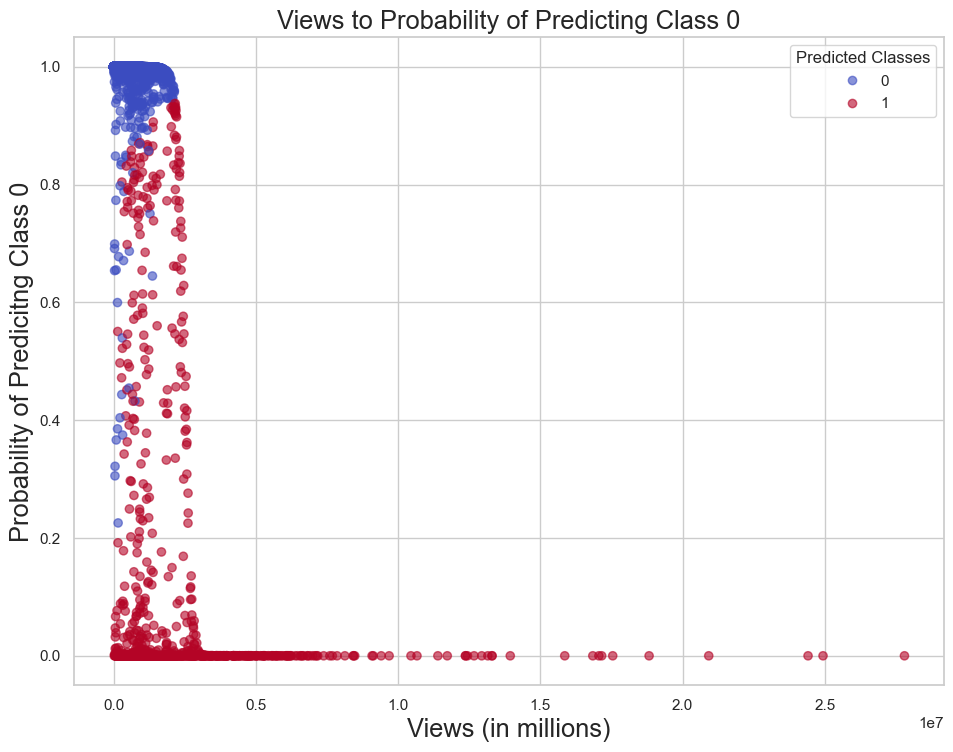

In [89]:
plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test_probs['views'], GNB_probs[:,0], 
                        c=X_test_probs['predict_class'], 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Views to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Views (in millions)', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Predicted Classes')
# ax.legend()

plt.show()

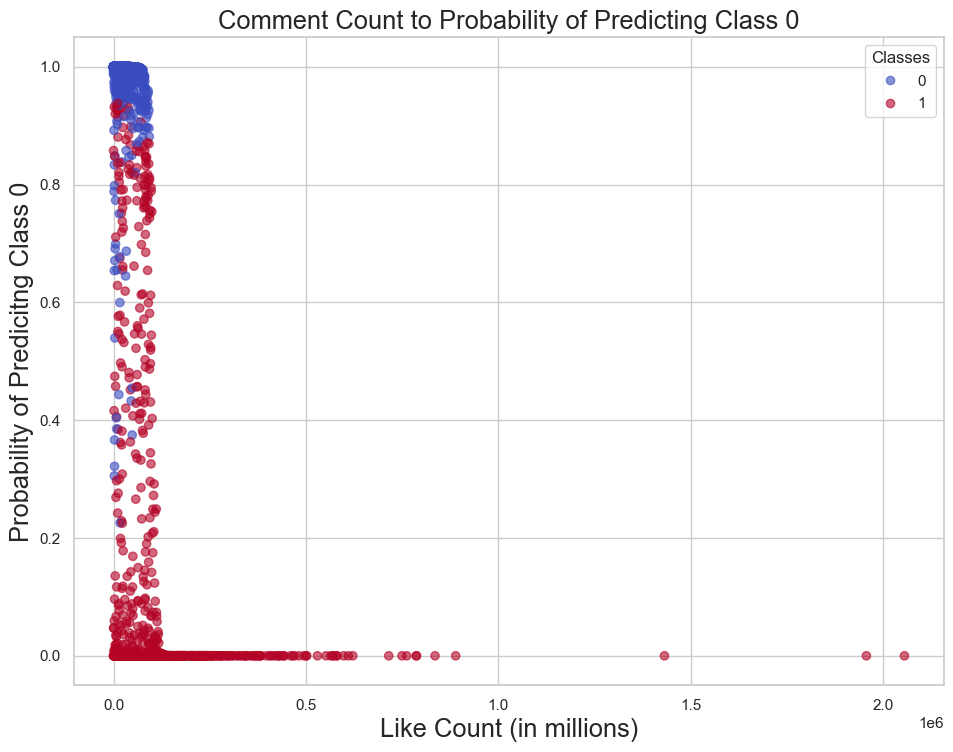

In [87]:
xrange = [i for i in range(len(GNB_probs[:,0]))]

plt.figure(figsize=(10, 8), dpi=100)

scatter = plt.scatter(X_test['comment_count'], GNB_probs[:,0], 
                        c=X_test_probs['predict_class'], 
                        cmap='coolwarm',
                        alpha=0.6)
plt.title('Comment Count to Probability of Predicting Class 0', fontsize='small')
plt.xlabel('Comment Count', fontsize='small')
plt.ylabel('Probability of Predicitng Class 0', fontsize='small')
plt.rcParams.update({'font.size': 22})


plt.legend(*scatter.legend_elements(), loc='upper right', title='Classes')
# ax.legend()

plt.show()

In [ ]:
GNB.feature_log_prob_

In [ ]:
X_test_probs

In [ ]:
# to first affirm that prob_0 and prob_1 were truly labeled as what they were supposed to be

count = 0
for i, row in X_test_probs.iterrows():
    count += 1
    if count > 5:
        break
    print(f'i:{i}, V:{row.views}, L:{row.likes}, D:{row.dislikes}, C:{row.comment_count}')
    print(f'i:{i}, Prob_0:{row.prob_0}, Prob_1:{row.prob_1}, Label:{row.label}\n')

In [ ]:
count = 0
for i, row in X_caltest_probs.iterrows():
    if 0.65 > row.prob_0 > 0.45:
        count += 1
        print(f'i:{i}, V:{row.views}, L:{row.likes}, D:{row.dislikes}, C:{row.comment_count}')
        print(f'i:{i}, Prob_0:{row.prob_0}, Prob_1:{row.prob_1}, Label:{row.label}\n')
        
print(f'\nCount = {count}')

### Other observations

In [ ]:
len(X_test)

In [ ]:
np.array(X_test[19:20])

In [ ]:
y_test[19:20]

In [ ]:
GNB.predict_proba(X_test[:-1])

In [ ]:
GNB.predict(X_test[5::-1])

In [ ]:
# custom 
print(GNB.predict(np.array([[17158579, 787425, 43420, 125882]])))
print(GNB.predict_proba(np.array([[17158579, 787425, 43420, 125882]])))

In [ ]:
# custom 
arr2 = [4567, 787, 430, 125]
print(GNB.predict(np.array([arr2])))
print(GNB.predict_proba(np.array([arr2])))

### Using only views, comments, and likes to graph 3D

In [ ]:
X3 = X.drop(['dislikes'],axis=1)
X3

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.25, random_state=42)

In [ ]:
X3_train

In [ ]:
y3_train

### Gaussian Naive Bayes on views, comments, likes, only

In [ ]:
GNB_3 = GaussianNB()
GNB_3.fit(X3_train, y3_train)

In [ ]:
GNB_3.score(X3_test, y3_test)

In [ ]:
from sklearn.model_selection import cross_val_score

GNB_3_cvs = cross_val_score(GNB_3, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(GNB_3_cvs)
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(GNB_3_cvs)}")

### Bernoulli Naive Bayes on 4 stats, then the 3 stats

In [ ]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

In [ ]:
BNB.score(X_test, y_test)

In [ ]:
BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

In [ ]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X3_train, y_train)

In [ ]:
BNB.score(X3_test, y_test)

In [ ]:
BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

### Random Forest Classifier on 4 stats, looking at feature importance

In [ ]:
%%time 
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

In [ ]:
%%time
rf_clf.score(X_test,y_test)

## Taking a look at feature importance from Random Forest

In [ ]:
# quick investigation into the correlation of features to the label
df_nostr.corr()["trend_over_5_days"].sort_values(ascending=False)

In [ ]:
rf_clf.feature_importances_

In [ ]:
plt.barh(X.columns, rf_clf.feature_importances_)

In [ ]:
%%time
import shap

explainer = shap.TreeExplainer(rf_clf)

In [ ]:
%%time
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shape_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shape_values, X_train)

In [ ]:
# X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
# y = np.array([1, 1, 2, 2])
# from sklearn.svm import SVC
# clf = SVC(probability=True)
# clf.fit(X, y) 
# print(clf.predict([[-0.8, -1]]))
# print(clf.predict_proba([[-0.8, -1]]))

### Heat Map remade with Spearman's rank correlation 

In [ ]:
import seaborn as sns

sns.heatmap(df_nostr.corr(method='spearman'),annot=True,cmap='coolwarm')

In [ ]:
sns.heatmap(df_nostr.corr(method='pearson'),annot=True,cmap='coolwarm_r')

In [ ]:
df_nostr.corr(method='pearson')['trend_over_5_days']